# Logistic Regression
_CardioPredict harnesses the power of logistic regression to analyze key health indicators and provide a predictive model for assessing the risk of coronary heart disease in individuals._

Data source: https://paulblanche.com/files/DataFramingham.html

by Joel Wu, Sandra Gross, He Ma and Doris Wang (DSCI 522 Group 10 Milestone 1)

2023/11/15

In [1]:
#Imports
import numpy as np
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

#### Load and split the data

In [2]:
# 1. import data and split into train and test
df = pd.read_csv("data/framingham.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [3]:
#Separate target value form train and test set 
X_train = train_df.drop(columns="disease")
y_train = train_df["disease"]

X_test = test_df.drop(columns=["disease"])
y_test = test_df["disease"]

#### Data
The dataset utilized is derived from the "Framingham Heart Study," encompassing observations on n=1,363 individuals. Each row contains  key health indicators for each person, as well as whether the person suffers from a coronary heart disease indicated by the values zero or one. 


#### Preprocessing Data
All the features appear to exhibit some relevance in predicting whether a patient has the disease or not. Therefore, we will refrain from excluding any feature from our model.

##### Numeric features:
- AGE
- FRW
- SBP
- DBP
- CHOl
- CIG
  
To account for some of the missing values in the numeric columns, we need to do imputation. Due to the skewed distribution of specific features, especially CIG, it's recommended to use the median of the corresponding columns rather than the mean for imputing missing values.
Moreover, given the varied scales of the features, it is essential to apply a StandardScaler.

In [4]:
#Create pipeline for numeric features 
numeric_pipe = make_pipeline(
    SimpleImputer(strategy = "median"), StandardScaler()
)

##### Categorical Feature: 
- SEX
  
In this data set, gender is considered a binary feature. Consequently, we can employ `OneHotEncoding` with the `drop="if_binary"`
 argument, resulting in the creation of a single binary-encoded column instead of two.

In [5]:
numeric_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = ["sex"]

In [6]:
#Create Column Transformer 
preprocessor = make_column_transformer(    
    (numeric_pipe, numeric_features),  
    (OneHotEncoder(drop="if_binary", sparse_output = False), categorical_features)
)

#### Model Selection
We are interested in determining whether a patient suffers from a disease or not, which constitutes a classification problem. To address this, we employ a `Logistic Regression model`. Considering the substantial class imbalance and the fact that we are rather concerned about false negatives in the medical context — as we aim to minimize instances where patients miss critical treatment — we should make use of the argument class_weight argument. By trying out different values for the `class_weight`, we see that 1:6 seems to gives as a satisfactory result for our recall-precision trade off.


In [7]:
pipe = make_pipeline(preprocessor, LogisticRegression(class_weight={0: 1, 1: 6}))

#### Hyperparameter Optimization
In order to find the best model and avoid under-/overfitting we want to improve the hyperparameter C of the LogisticRegression via Gridsearch.

In [8]:
# Create a grid search object to fine tune c
param_grid = {
  "logisticregression__C": 10.0 ** np.arange(-4, 6, 1),
}
gs = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['AGE',
                                                                          'FRW',
                                                                          'SBP',
                                                                          'DBP',
                                                                          'CHOL',
                                                                          'CIG']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         ['sex'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 6}))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])},
             return_train_score=True)

In [9]:
gs_res = pd.DataFrame(gs.cv_results_)[[
    'rank_test_score', 'param_logisticregression__C', 
    'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].sort_values('rank_test_score').head(5)
gs_res.style.set_caption('<p style="text-align:left;">Table 1: Results of Hyperparameter Optimization via Gridsearch</p>')

,rank_test_score,param_logisticregression__C,mean_train_score,std_train_score,mean_test_score,std_test_score
7,1,1000.000000,0.526835,0.025495,0.519266,0.032097
8,1,10000.000000,0.526835,0.025495,0.519266,0.032097
9,1,100000.000000,0.526835,0.025495,0.519266,0.032097
4,4,1.000000,0.526835,0.025495,0.518349,0.030150
5,4,10.000000,0.526835,0.025495,0.518349,0.030703


In [10]:
gs.best_params_ #value for C: 1000

{'logisticregression__C': 1000.0}

In [11]:
gs.best_score_

0.5192660550458716

#### Applying on test data

In [12]:
gs.score(X_test, y_test)

0.5531135531135531

For test data, we get an accuracy of 53.1%. The accuracy is a metric which is defined to be the fraction of correct predictions divded by all predictions. 
This implies, that in 53% of our test examples we predict the target correctly, which seems to be pretty low. However, as mentioned above we should be careful when interpreting this metric especially in the case of the class imbalance, which is given in our data set. Instead, we should examine how the model predictions are correct and incorrect. 

#### Visualization of Predictions Results

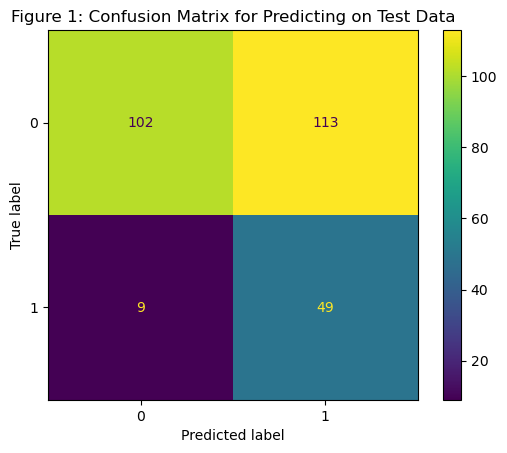

In [13]:
#Create a Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,  # true class labels
    gs.predict(X_test),  # predicted class labels
)
plt.title('Figure 1: Confusion Matrix for Predicting on Test Data')
plt.show()

In [27]:
#Classification report
print('Table 2: Classification Report for Test Data')
print(
    classification_report(
        y_test, gs.predict(X_test)
    )
)

Table 2: Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.92      0.47      0.63       215
           1       0.30      0.84      0.45        58

    accuracy                           0.55       273
   macro avg       0.61      0.66      0.54       273
weighted avg       0.79      0.55      0.59       273



In the graphic and the classification report we can see that we have a very high recall score (0.84), which is desired in our scenario. However, the precision score with a value of 0.30 is pretty low as we have many false positives (Type I error) rather than false negatives, type II errors.